In [274]:
import pandas as pd
from collections import namedtuple, OrderedDict
import datetime
import ujson
import os
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
import math
import time
import gzip
from importlib import reload
import utils
reload(utils)
from utils import (load_data, clip_start_date, clip_end_date, timedelta_to_ms_hr, time_ticks, bound_data, total_days, MIN_TIME_PER_CATEGORY, 
                   filter_data, redact, cut_categories, groupby_columns_total_time, resample_total_time_by_day, top_categories)
from tqdm import tqdm_notebook

sns.set(font_scale=1.3)
from jupyterthemes import jtplot
jtplot.style()

LOGS = './logs/'
Window = namedtuple('Window', 'pid name start_time last_update focus_time exe cmd')
Event = namedtuple('Event', 'time category text index')

In [275]:
data = load_data(40)

In [276]:
anonymize = True # replace all category names with <REDACTED> when plotting
category_count = 10
# category_count = 0
start_date = '2019-01-01'
# start_date = None
end_date = '2018-12-31'
end_date = None
ignored_categories = ['afk']
# ignored_categories = []

# Prepare data
data_filtered = filter_data(data, ignored_categories)
data_bounded, start_date_bounded, end_date_bounded = bound_data(data_filtered, start_date, end_date)

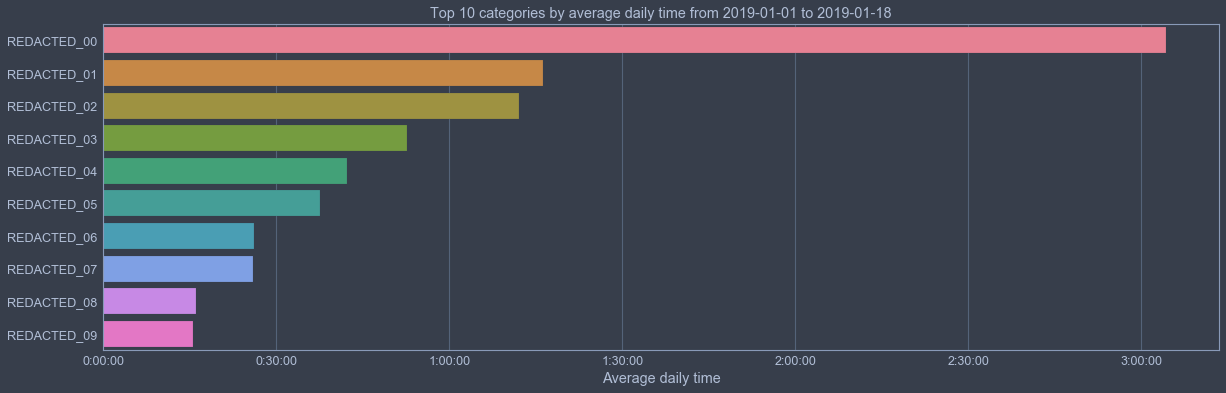

In [277]:
# def plot_top_categories(category_count=None, start_date=None):

# Wrangle data
d = top_categories(data_bounded, category_count) # Categories by sum focus_time
average_per_day_format = lambda x: timedelta_to_ms_hr(x) / total_days(data_bounded)
d = d.apply(average_per_day_format)

# Plot data
category_count_plot = len(d.index)
plt.figure(figsize=(20,6))
d = redact(d, anonymize)
ax = sns.barplot(x=d.values, y=d.index, orient='h', palette=sns.color_palette('husl', category_count_plot))
ax.set_title(f'Top {category_count_plot} categories by average daily time from {start_date_bounded.date()} to {end_date_bounded.date()}')
ax.set_xlabel('Average daily time')
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(time_ticks))
# plot_top_categories(10, start_date='2000-01-01')

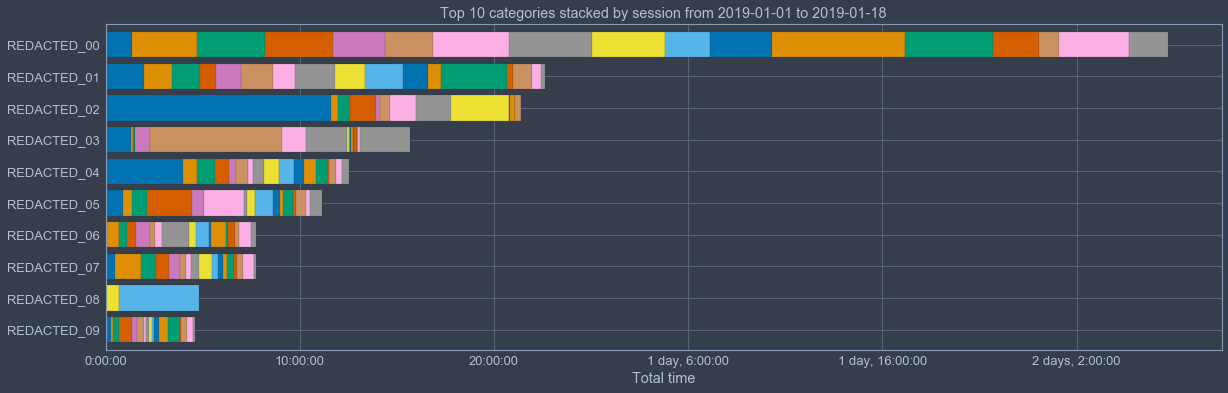

In [278]:
# def plot_top_by_date(category_count=None, start_date=None):
legend = False
from utils import groupby_columns_total_time_unstack, reindex_by_total_time_cut

# TODO: extract top_categories
# TODO: handle daily tick marks

# Wrangle data
categories = top_categories(data_bounded, category_count).index
d = data_bounded[data_bounded.category.isin(categories)]
d = d.set_index('start_time').groupby('category').resample('D').focus_time.sum().unstack(level=1) # Every category's time per day
d = d.apply(timedelta_to_ms_hr)
d = d.loc[categories][::-1]  # Use sorted category list

# Plot data
category_count_plot = len(d.index)
sns.set_palette('colorblind')
d = redact(d, anonymize, reverse=True)
ax = d.plot.barh(stacked=True, figsize=(20,6), width=0.8, fontsize=13, legend=legend)
if legend:
    ax.legend(loc='lower right', bbox_to_anchor=(0, 0, 1, 1))
ax.set_title(f'Top {category_count_plot} categories stacked by date from {start_date_bounded.date()} to {end_date_bounded.date()}')
ax.set_xlabel('Total time')
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(time_ticks))

#plot_top_by_date(15, '2016-01-01')
# plot_top_by_date(10, start_date='2017-10-01')
#plot_top_by_date(10)

Total time of "REDACTED" = 0 days 22:38:00


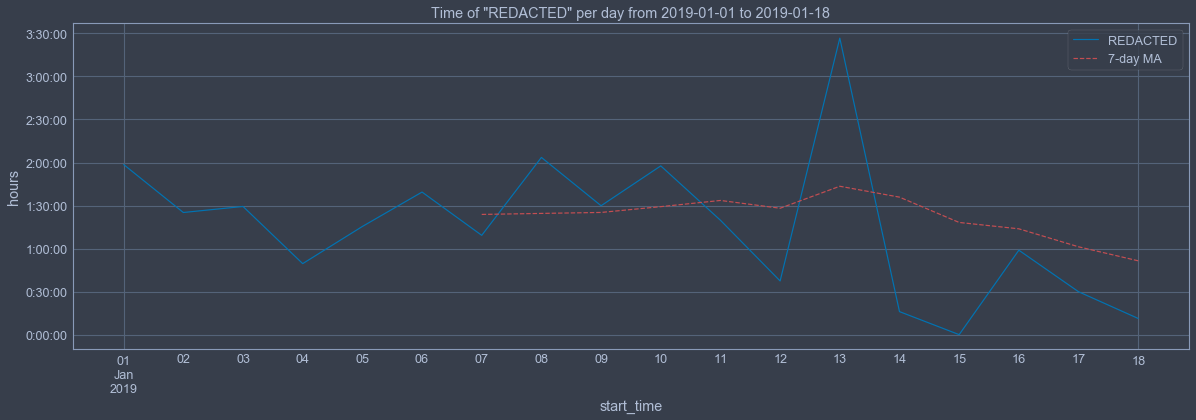

In [280]:
# def plot_category_by_day(category, start_date=None, end_date=None):
category = 'Code.exe'

# Wrangle data
d = data_bounded[data_bounded.category.str.lower() == category.lower()]
if anonymize: category = 'REDACTED'
print(f'Total time of "{category}" =', d.focus_time.sum().round('1min'))
d = resample_total_time_by_day(d)
d = d.apply(timedelta_to_ms_hr)
rolling_mean = d.fillna(0.0).rolling(7).mean()  # 7-day moving average

# Plot data
sns.set_palette('colorblind')
ax = d.plot(figsize=(20,6))
rolling_mean.plot(ax=ax, style='r--')
ax.set_title(f'Time of "{category}" per day from {start_date_bounded.date()} to {end_date_bounded.date()}')
ax.legend([category, '7-day MA'])
ax.set_ylabel('hours')
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(time_ticks))

# plot_category_by_day('REDACTED', start_date='2014-07-01')  # category manually redacted

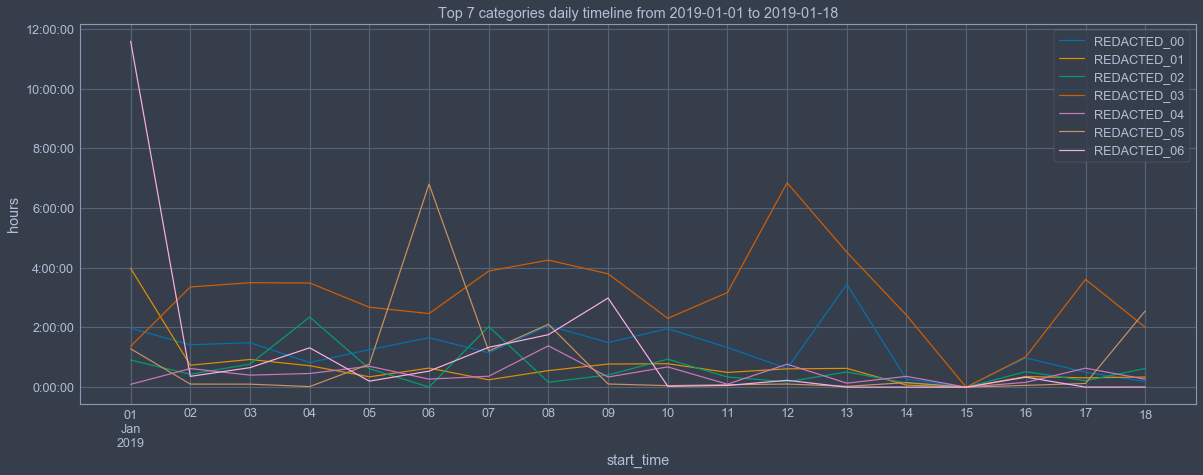

In [281]:
#def plot_timeline_by_category_time(category_count, start_date=None, end_date=None):
from utils import top_categories_index
# sns.set_palette('Set1', int(category_count*1.2))

category_count = 7

categories = top_categories(data_bounded, category_count).index
d = data_bounded[data_bounded.category.isin(categories)]
d = d.set_index('start_time') \
     .groupby('category') \
     .resample('D')['focus_time'].sum() \
     .apply(timedelta_to_ms_hr) \
     .unstack(level=0)
# TODO: ffill 0
# TODO: stacked area chart normalized

##d = d.groupby(['category', 'boot']).focus_time.sum().unstack(0)
##d = d[categories].resample('D').sum().fillna(pd.Timedelta(0)).apply(timedelta_to_ms_hr)
#for i in range(category_count):
#ax = d.iloc[:,i].plot(figsize=(27,7), x_compat=False, label=d.columns[i])
if anonymize: d.columns = [f'REDACTED_{i:02}' for i in range(category_count)]
    
ax = d.plot(figsize=(20,7), )  # x_compat=False
ax.set_title('Top {} categories daily timeline from {} to {}'.format(category_count, 
                                                                     start_date_bounded.date(), 
                                                                     end_date_bounded.date()))

ax.xaxis.grid(True, which="minor")
ax.set_ylabel('hours')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(time_ticks))

# plot_timeline_by_category_time(8, start_date='2017-11-01', end_date='2020-01-01')

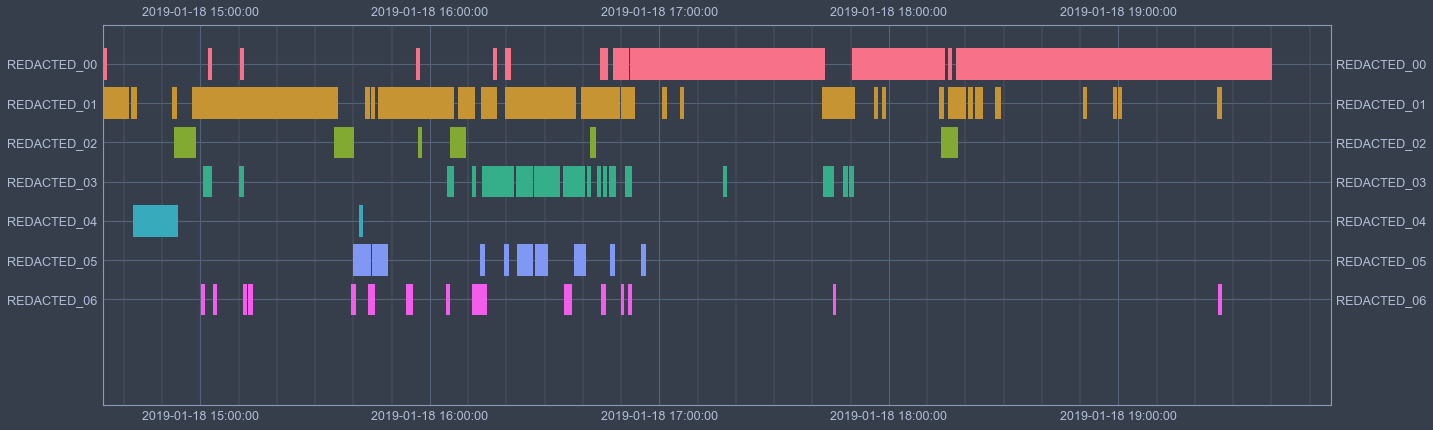

In [282]:
# def plot_day_sequence_chart(category_count, date=None):

category_count = 7
start_date = pd.Timestamp.now() - pd.Timedelta('8 hours')
end_date = None

# Prepare data
data_bounded, start_date_bounded, end_date_bounded = bound_data(data_filtered, start_date, end_date)

import utils  # need to pass variables back to utils
def add_event_vline(event):
    pos = timedelta_to_ms_hr(event.time - boot_time_round)
    y = -1.3
    plt.axvline(pos, color=palette[sequence_categories.index(event.category)])
    plt.text(pos, -1-0.7*(event.index%3), event.text, rotation=0, fontsize=13)

sequence_categories = top_categories(data_bounded, category_count).index[::-1]
day = data_bounded[data_bounded.category.isin(sequence_categories)]
# utils.sequence_categories = sequence_categories

d = day.set_index('category')[['focus_time', 'last_update', 'start_time']]
# d['start_time'] = d['last_update'] - d['focus_time']
# d['focus_time'] = d['focus_time'].apply(timedelta_to_ms_hr)
d = d.sort_values('start_time')
boot_time = day['start_time'].min()
boot_time_round = boot_time.replace(minute=0, second=0)
utils.boot_time_round = boot_time_round

fig = plt.figure(figsize=(22,7))
ax = fig.add_subplot(111)
palette = list(reversed(sns.color_palette('husl', category_count)))

pad = 60*1000/3.6  # 60sec = expand length of event for quick events
stitch = 60*1000/3.6 # 60sec = events with a (gap < stitch) become one

# stitching
d2 = []
for category in set(d.index):
    group = d[d.index == category].reset_index()
    stime = group.iloc[0].start_time
    ltime = group.iloc[0].last_update
    lg = len(group)
    if lg==1:
        d2.append(pd.Series(index=['start_time', 'last_update', 'focus_time'], name=category,
                 data=[stime, ltime, timedelta_to_ms_hr(ltime - stime)]))
    group['gap'] = timedelta_to_ms_hr(group['start_time'] - group.shift(1)['last_update'])
    for row in range(1, lg+1):
        if row==lg or (group.iloc[row].gap > stitch and row < lg):
            d2.append(pd.Series(index=['start_time', 'last_update', 'focus_time'], 
                                name=category,
                                data=[stime, 
                                      group.iloc[row-1].last_update, 
                                      timedelta_to_ms_hr(group.iloc[row-1].last_update - stime)]))
            if row < lg:
                stime = group.iloc[row].start_time
d2 = pd.DataFrame(d2)

# plotting
for k, v in d2.iterrows():
    # pad to the left and to the right to reduce noise
    category = sequence_categories.get_loc(k)
    ax.barh(y=category, 
            width=v['focus_time'] + pad, # Extend by 1 minute to the right
            height=.8,
            left=timedelta_to_ms_hr(v['start_time'] - boot_time_round) - pad, # Extend by 1 minute to the left
            align='center', 
            color=palette[category],
            edgecolor = 'none')

from utils import date_boot_ticks

ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(date_boot_ticks))
# ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(label_ticks))
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(6))
ax.tick_params(labelright=True, labeltop=True)
ax.grid(b=True, which='minor', color='w', linewidth=0.1)
# ax.grid(b=True, which='major', color='w', linewidth=0.3)
ax.set_yticks(range(len(sequence_categories)))
ax.set_yticklabels(sequence_categories)
if anonymize: ax.set_yticklabels([f'REDACTED_{i:02}' for i, _ in enumerate(sequence_categories)][::-1])
ax.set_ylim(-2.7, len(sequence_categories))
# ax.grid(which='minor', linewidth=0.1)
# ax.grid(which='major', linewidth=0.3)
# ax.yaxis.grid(which='major', linewidth=0.1)

# TODO: delete todo axvline

# plot 'todo' category events as vertical lines, color by category with most time in +-10min
event_delta = pd.Timedelta('10min')
todos = data_bounded[data_bounded['category'] == 'todo'].sort_values('last_update')
for i, (_, event_row) in enumerate(todos.iterrows()):
    event_time = event_row['last_update'] - event_row['focus_time'] 
    intersections = day[(event_time - event_delta < day['last_update'] - day['focus_time']) & 
                        (day['last_update'] - day['focus_time'] < event_time + event_delta) | 
                        (event_time - event_delta < day['last_update']) & 
                        (day['last_update'] < event_time + event_delta) | 
                        (day['last_update'] - day['focus_time'] < event_time) & 
                        (event_time < day['last_update'])]
    if not intersections.empty:
        category = intersections.groupby('category')['focus_time'].sum().idxmax()        
        add_event_vline(Event(event_time, category, event_row['name'].split('- TODO')[0], i))

# plot_day_sequence_chart(7)